# Introduction to optimization and curve fitting: Analysis of neutron diffraction patterns due to antiferromagnetism

    Name: Beltran Sajonia-Coburgo-Gotha
    ID: 170449861
    Due date: Sunday 11 November, 11:59 pm

## 1. Introduction

Magnetism is caused by the allignment of magnetic moments in a solid, where the overall result is a net magnetic moment. However, it could be the case that alternate magnetic moments point in opposite directions so that the solid has no net magnetic moment. This is alternating pattern is called antiferromagnetism and because it increases the crystallographic unit cell size, one can observe characteristic peaks in neutron diffraction patterns.

Because thermal energy disrupts the arrangement, antiferromagnetism typically happens only at very low temperatures. We will denote the *transition temperature* as *T<sub>o*, below which the solid exhibits antiferromagnetism, and the *critical exponent* as *β*, which describes how rapidly the magnetic moments order. The data analysed was collected at ISIS, and the material is also a manganese(II) compound, methylammonium manganese(II) formate (CH<sub>3</sub>NH<sub>3</sub>Mn(HCO<sub>2</sub>)<sub>3</sub>) [[1](http://dx.doi.org/10.1039/C6TC03992H)]

The transition temperature can be determined by integrating the intensity of the diffraction pattern and plotting the results against the temperature, after which it will be the point where the intensity becomes constant. The critical exponent was obtained by fitting the data using curve_fit from the scipy.optimize module and the Matrix operation with Newton-Raphson techniques learned during the relevant Labs. However, the original model function was highly susceptible to initial conditions so this report evaluates the use of updated model function, which models the background as a negative exponential decay. This proved to ease the susceptibility to initial conditions so matrix operation with Newton-Raphson could be used. Also, the diffraction intensity peaks can be modelled using Lorentzian functions. Thus, after integrating the Lorentzian fits, the resulting $I(T)$ graph is very similar to the original $I(T)$ graph, confirming Lorentzian fits are an adequate fit to the diffraction intensity peaks for this particular data.

## 2. Methods

The following section gives a description of how the functions used throughout the report work. The main purposes of the code are: 
- Importing Files + Model Equations
- Mathematical Methods
- Curve Fitting Functions + Results Display

### 2.1 Importing Files + Model Equations

In [1]:
import numpy as np
import pylab as plt
import math as m
from math import exp
from scipy.optimize import curve_fit
import warnings; warnings.simplefilter('ignore') #disables warning messages for improved readility
%matplotlib inline   
#use %matplotlib notebook for interactive plot  

In [2]:
def file_import(file):
    path="/Users/beltran/ap17163/project2_data/"
    imported = np.loadtxt(path+file)
    return imported[:,0],imported[:,1]
    #returns the x and y values of the data
filenames= ['data_02.0K.txt','data_03.0K.txt','data_04.0K.txt','data_06.5K.txt','data_07.5K.txt',
            'data_10.0K.txt','data_15.0K.txt','data_30.0K.txt']
temperatures = [2.0, 3.0, 4.0, 6.5, 7.5, 10.0, 15.0, 30.0]

*file_import* is used to import the data files insider the folder and requires the folder directory path to be specified (pwd!). It takes the name of the file as an argument, and returns the x and y values specified in the file. Note that the file names have been specified as a list, which will allow us write a loop and plot all of the folder data.

In [3]:
def M(T,parameters):
    A,T0,Be,B = parameters
    result = np.where(T<T0,A*(T0-T)**Be + B , B)
    return result

def Mupdate(T,parameters):
    A,T0,Be,B,gradient,alpha = parameters
    kappa=intensity_t[7]- alpha*np.e**(-gradient-T0)
    result = np.where(T<T0,A*(T0-T)**Be + B ,alpha*(np.e**(-gradient*(T-T0))) + kappa)
    return result

def MSci(T,A,T0,Be,B,gradient,alpha):
    kappa=intensity_t[7]- alpha*np.e**(-gradient-T0)
    result = np.where(T<T0,A*(T0-T)**Be + B ,alpha*(np.e**(-gradient*(T-T0))) + kappa)
    return result

$M(T)$ is the provided function used to fit the data, as well as the function used to find the transition temperature $T_0$ and the critical exponent $\beta$, given mathematically by:

$$
M(T) = \begin{cases}A(T_0 - T)^\beta + B & T < T_0 \\ B & T \geq T_0\end{cases}
$$

$$
M_{update}(T) = \begin{cases}A(T_0 - T)^\beta + B & T < T_0 \\ \alpha e^{-\gamma(T-T_0)} + \kappa & T \geq T_0\end{cases}.
$$

The other function $M_{update}(T)$ is the same as $M(T)$ for $T<T_0$ but uses a negatively exponential fit for $T \geq T_0$ instead of the constant $B$. The profound implications of this subtle change will become apparent in the Results section and will be evaluated as part of the Discussion. *MSci* is simply the form $M_{update}(T)$ needs to take to be usable with *curve_fit*. Although $M_{update}(T)$ seems to have 3 independent parameters for $T<T_0$, the constraints for placed by its continuity and its value at $T=30K$ allow us to write $\kappa$ in terms of the $\alpha$ and $\gamma$ s.t. $$\kappa = I_{30} -\alpha e^{-\gamma-T_0}$$

### 2.2 Mathematical Methods

The next set of functions provide the necessary mathematical machinery to compute the curve that best fits the data using matrix algebra and Newton-Raphson. The idea behind this machinery is the following:

We are given a fitting function $M(T;\mathbf{p})$ where our parameters are by $\mathbf{p} = (A, T_0, \beta,...)$. We then find reasonable estimates for these parameters so that it resembles the data given. If we let $j$ equal the number of independent parameters, we can specify a function $\mathbf{g}(\mathbf{p})$ where the components $g_j$ will form the Jacobian matrix:

$$
g_j(p_1, p_2, p_3) = \sum_{i=1}^n\big(M(T_i) - I_i\big)\frac{\partial L}{\partial p_j}(T_i) \qquad
$$
$$
\frac{\partial\mathbf{g}}{\partial\mathbf{p}} = \begin{pmatrix}
        \frac{\partial g_1}{\partial p_1} & \frac{\partial g_1}{\partial p_2} & \dots & \frac{\partial g_1}{\partial p_q} \\
        \frac{\partial g_2}{\partial p_1} & \frac{\partial g_2}{\partial p_2} & \dots & \frac{\partial g_2}{\partial p_q} \\
        \vdots & \vdots & \ddots & \vdots \\
        \frac{\partial g_q}{\partial p_1} & \frac{\partial g_q}{\partial p_2} & \dots & \frac{\partial g_q}{\partial p_q} 
      \end{pmatrix}.
$$

Using the multi dimensional Newton-Raphson method, each iteration we replace **p** by the expression below until fit our data for a given tolerance.

$$
\mathbf{p}-\left(\frac{\partial\mathbf{g}}{\partial\mathbf{p}}\right)^{-1}\mathbf{g}(\mathbf{p}).
$$

In order to evaluate the accuracy of our fit to the data we use the reduced chi-squared method given by:

$$
\chi^2_\text{red} = \frac{\sum_i(y_\text{fitted} - y_\text{observed})^2}{k + 1}.
$$

where k +1 is the number of coefficients

In [4]:
def CD(f, x0, h):
    return (f(x0 + h/2) - f(x0 - h/2))/np.linalg.norm(h)

def g(param,data): #data is inserted as a tuple of the x(temperature) and y(Intensity values)
    A,T0,Be,B,gradient,alpha = param
    T,y = data
    #Calculating all of the partial derivatives
    dMdA=(T0-T)**Be
    dMdT0=Be*A*(T0-T)**(Be-1)
    dMdBe=A* (T0-T)**Be *np.log(Be)
    dMdB=1
    dMdalpha=np.e**(-gradient*(T-T0)) 
    dMdgrad=-(T-T0)*alpha*np.e**(-gradient*(T-T0))
    dMdT02= alpha*gradient*np.e**(-gradient*(T-T0))
    dMdkappa = 1
    g1 = np.sum((y - Mupdate(T,param))*np.where(T<T0,dMdA,0))
    g2 = np.sum((y - Mupdate(T,param))*np.where(T<T0,dMdT0,dMdT02))
    g3 = np.sum((y - Mupdate(T,param))*np.where(T<T0,dMdBe,0))
    g4 = np.sum((y - Mupdate(T,param)))
    g5 = np.sum((y - Mupdate(T,param))*np.where(T>T0,0,dMdalpha))
    g6 = np.sum((y - Mupdate(T,param))*np.where(T>T0,0,dMdgrad))
    return g1,g2,g3,g4,g5,g6

def jacobian(g, param, data):
    p = np.array(param)
    delta = 1e-6
    N = len(param)
    jac = np.zeros((N,N))
    for i in range(N):
        def g_i(x):
            return g(x, data)[i]
        for j in range(N):
            dv = np.zeros(N)
            dv[j] = delta
            jac[i,j] = CD(g_i, p, dv)
    return jac

def coefficient_matrix(x, k):
    matrix = np.zeros((k+1, k+1))
    for i in range(k+1):
        for j in range(k+1):
            matrix[i,j] = sum(x**(i+j))
    return(matrix)

def nD_Newton_step(g, p, data):
    pnew= p - np.linalg.inv(jacobian(g,p,data))@g(p,data)
    return pnew

def Convergence(param,eps):
    converged = False
    iterations=0
    while not converged:
        p1 = nD_Newton_step(g, param, (temperatures, intensity_t))
        iterations+=1
        if np.linalg.norm(p1 - param) < eps:
            converged = True
            p0=p1
        elif iterations>20:
            p0=p1
            break
    return p0

def chi_squared(fit, obs, coefficients):
    denom=coefficients.size
    num=sum((fit-obs)**2)
    return(num/denom)

### 2.3 Curve Fitting Functions + Results Display

Given that the diffraction intensity peaks are of a known shape, the folloing functions can be used to model diffraction instensity peaks. $G$ represents a Gaussian funtion, $L$ represents a Lorentzian function and  $V$ represents a Voigt function, which is a linear combination of the Gaussian and Lorentzian where $\mu$ represents the weight coefficient. i.e. how closely the function is a Gaussian or a Lorentzian. $c$ represents the background.

$$
G(x; \mathbf{A,x_{0},D})= \frac{A}{D \sqrt{2 \pi}} exp\Big({\frac{-1}{2}\Big(\frac{x-x_0}{D}\Big)^2}\Big) + c
$$

$$
L(x; \mathbf{A,x_{0},D})= \frac{A}{\pi} \frac{1}{\Big( (x-x_0)^2 + D^2 \Big)} + c
$$

$$
V(x; \mathbf{\mu,A,x_{0},D}) = \mu \mathbf{G(x)} + (1-\mu) \mathbf{L(x)}
$$

In [5]:
def G(x,A,X0,D,background=0.4):
    factor = A/(D*m.sqrt(2*np.pi))
    exponential = -0.5 * ((x-X0)/D)**2
    return  factor*np.e**(exponential)+background

def L(x,A,X0,D,background=0.4):
    factor = A/np.pi
    denom = 1/((x-X0)**2 + D**2)
    return (factor*denom) + background

def V(x,mu,A,X0,D):
    return mu*G(x,A,X0,D) + (1-mu)*L(x,A,X0,D)

def Curve_2(iteration,total,i): #This function plots the Gaussian and Lorentzian fit for a given number
                               #Data set and will subplot them in the same line 
    subplot_title = temperatures[iteration-1]
    x_test,y_test = file_import(i)
    x_diffraction = np.linspace(6.3,7.1,121)
    amplitude = max(y_test)
    centre = 6.92
    width = 0.05
    param = np.array([amplitude,centre,width])
    fitted_Gy,c = curve_fit(G,x_diffraction,y_test,param)
    fitted_Ly,c = curve_fit(L,x_diffraction,y_test,param)
    Lchi_val = chi_squared(L(x_diffraction,*fitted_Ly),y_test,fitted_Ly)
    Gchi_val = chi_squared(G(x_diffraction,*fitted_Gy),y_test,fitted_Gy)
    plt.subplot(1,total,iteration)          #This line is the one that creates the subplots.
    plt.plot(x_diffraction,G(x_diffraction,*fitted_Gy),label='Gauss fit')
    plt.plot(x_diffraction,L(x_diffraction,*fitted_Ly),label= "Lorentzian fit")
    plt.plot(x_test,y_test,label="data")
    plt.ylabel("Diffracted intensity")
    plt.xlabel("d-spacing ($10^{-10}$m)")
    plt.title("Temperature: "+str(subplot_title)+"K")
    plt.legend()
    return fitted_Ly,Lchi_val,Gchi_val

## 3. Results

The report found three key results:
- Intensity(T): Integration and $M_{updated}(T)$ vs $M(T)$
- Lorentzian Diffraction Peaks
- Transition temperature and critical exponent

### 3.1 $Intensity(T)$ : *Integration and* $M_{updated}(T)$ *vs* $M(T)$

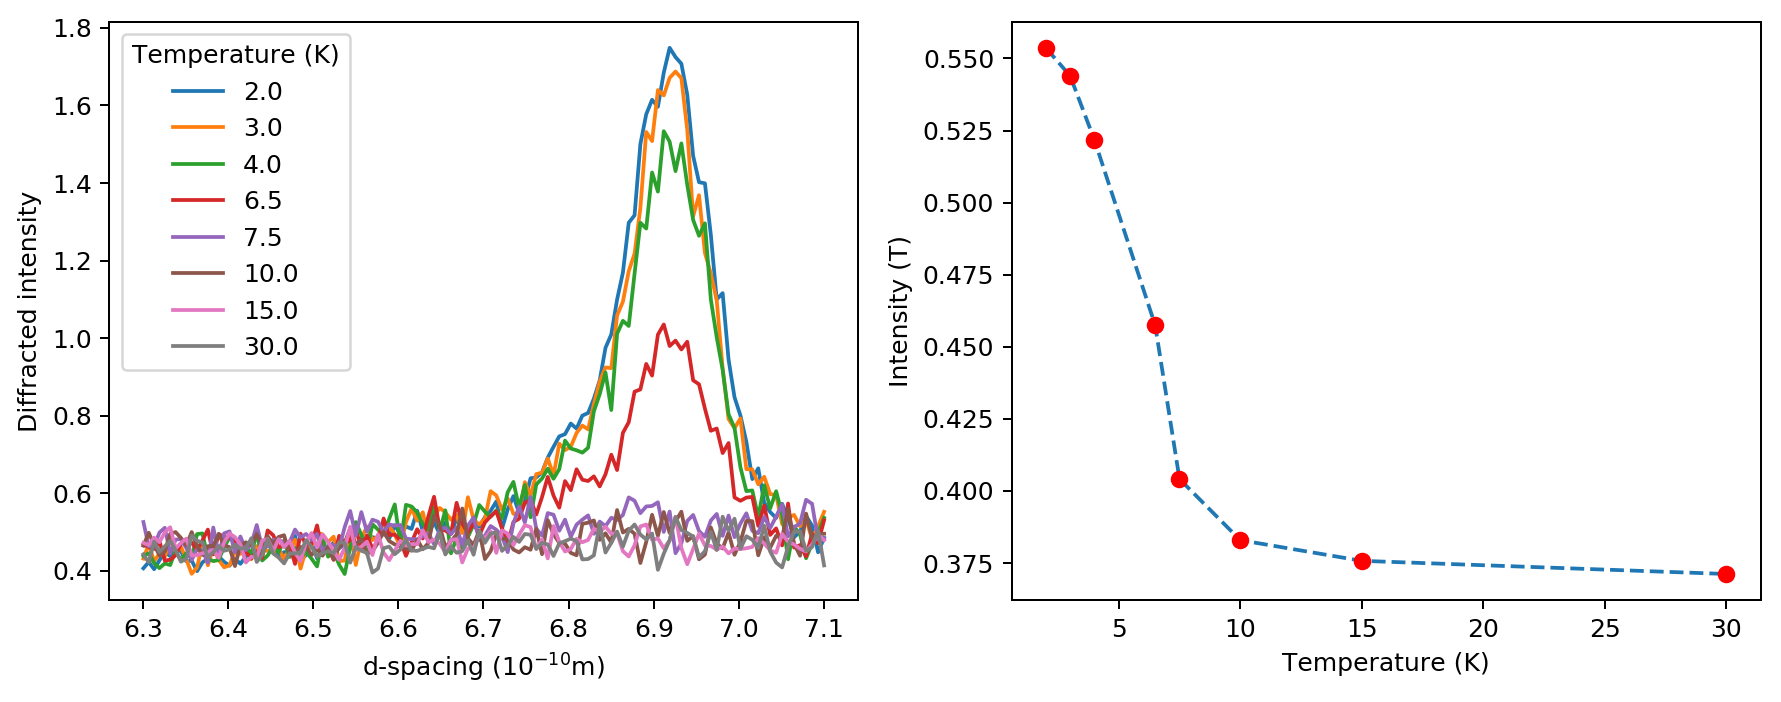

In [29]:
fig=plt.figure(figsize=(10, 4), dpi= 180, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
for i in range(len(filenames)):
    x1,y1 = file_import(filenames[i])
    plt.plot(x1,y1,label=temperatures[i])
    plt.legend()
plt.xlabel("d-spacing ($10^{-10}$m)")
plt.ylabel("Diffracted intensity")
plt.legend(title="Temperature (K)")

plt.subplot(1, 2, 2)
intensity_t = []
for elem in filenames:
    x_val, y_val = file_import(elem)
    intensity_t.append(np.trapz(y_val,x_val))
        #Using numpy trapezoid function to integrate the area under each of the temperature curves
plt.plot(temperatures,intensity_t,linestyle='dashed',label="Intensity (T)")
plt.plot(temperatures,intensity_t,'o',color='r')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity (T)")
plt.tight_layout()
plt.show()

The first figure shows all of the given data plotted in the same graph. The second figure shows the Intensity as a function of temperature, which was produced by integrating the curves in the first graph with np.trapz and plot it against the temperatures at which the data was recorded. The critical temperature $T_0$ can deduced from the second figure as the temperature at which the intensity becomes almost constant and the critical exponent $\beta$ is the 'steepness' that the intensity decays.

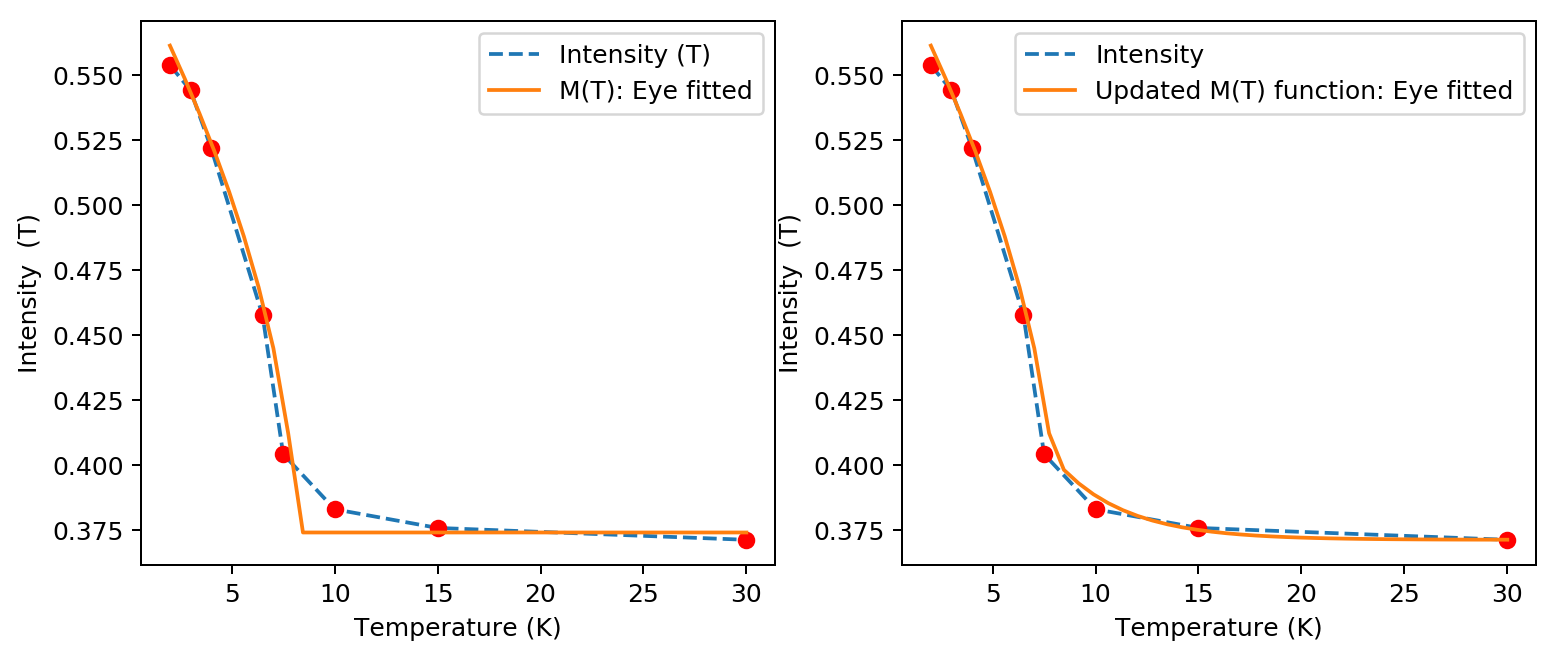

M(T) reduced chi-squared value: 
  0.000154
Mupdated(T) reduced chi-squared value:
  0.000092


In [31]:
fig=plt.figure(figsize=(10, 4), dpi= 180, facecolor='w', edgecolor='k')    
plt.subplot(1,2,1)
plt.plot(temperatures,intensity_t,linestyle='dashed',label="Intensity (T)")
plt.plot(temperatures,intensity_t,'o',color='r')
eye_param=(0.068,8.1,0.56,0.374)
x_values=np.linspace(2,30,40)
y_eye=M(x_values,eye_param)
plt.plot(x_values,y_eye,label="M(T): Eye fitted")
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity  (T)")
plt.legend()
plt.subplot(1,2,2)
param_updated=(0.068,8.1,0.56,0.374,0.3,0.03) #Initial guesses for updated M function
y_updatedM = Mupdate(x_values,param_updated)
plt.plot(temperatures,intensity_t,linestyle='dashed',label="Intensity")
plt.plot(temperatures,intensity_t,'o',color='r')
plt.plot(x_values,y_updatedM,label="Updated M(T) function: Eye fitted")
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity  (T)")
plt.legend()
plt.show()

print("M(T) reduced chi-squared value: ")
print("{:10.6f}".format(chi_squared(M(temperatures,np.array(eye_param)),intensity_t,np.array(eye_param))))
print("Mupdated(T) reduced chi-squared value:")
print("{:10.6f}".format(chi_squared(Mupdate(temperatures,np.array(param_updated)),intensity_t,np.array(param_updated))))

#chi_squared(Mupdate(temperatures,np.array(test2_param)),intensity_t,np.array(test2_param)))

The first graph shows the given $M(T)$ plotted against the original data $Intensity(T)$. The second graph shows $M_{updated} (T)$, which is $M(T)$ with the exponential decay for $T\geq T_0$. The reduced chi-squared values show that $M_{updated} (T)$ is a better fit to the data. However, the sharp peak (discontinuity) in the original $M(T)$ implies that curve fitting techniques are highly sensitive to the initial parameters, and the eye fitted parameters are already a better fit than the ones obtained with scipy or matrix operations with Newton-Raphson. Thus, although $M_{updated} (T)$ does not improve substantially the fit accuracy, it allows us to use curve-fitting methods without so many constraints or susceptibility to initial parameters, shown below:

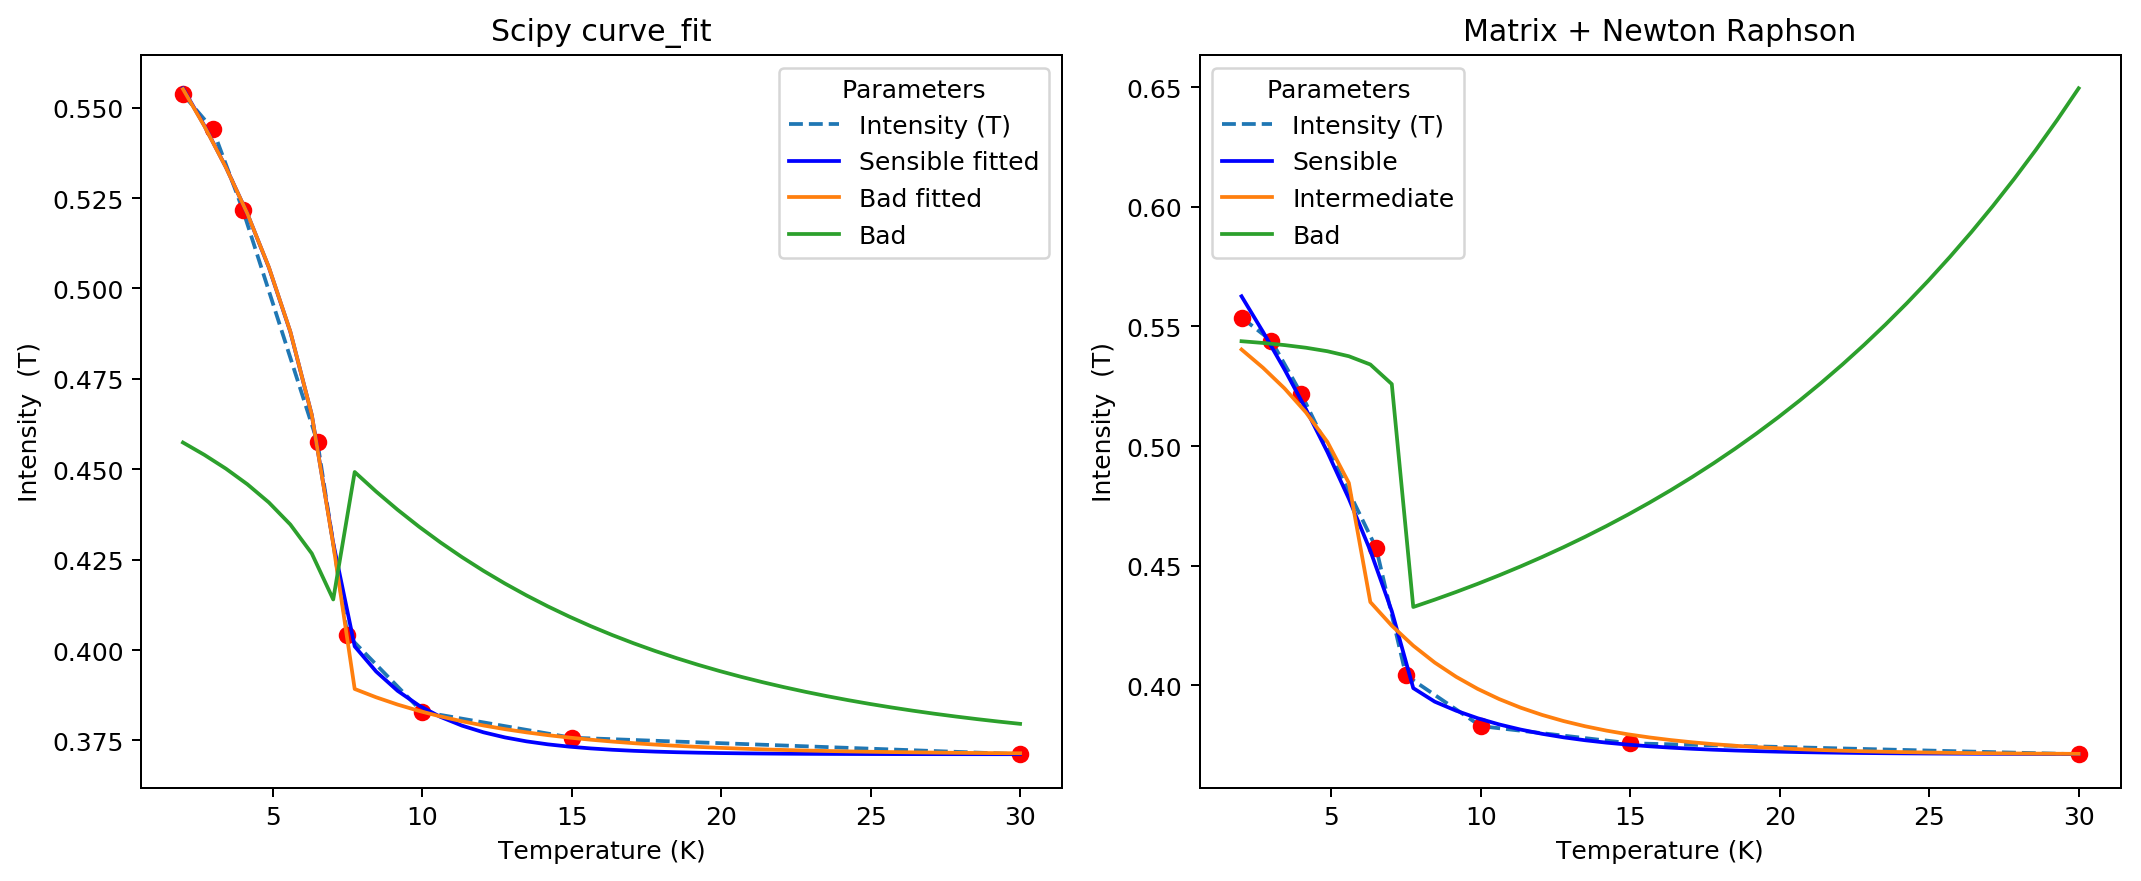

In [8]:
fig=plt.figure(figsize=(12, 5), dpi= 180, facecolor='w', edgecolor='k')
#FIGURE 1: SCIPY CURVE_FIT
plt.subplot(1, 2, 1)
Mupd_param=[0.068,8.1,0.56,0.374,0.3,0.03]
test2_param=[0.05,7.5,0.3,0.374,0.1,0.08]
solutions1,covariance = curve_fit(MSci,np.array(temperatures),intensity_t, Mupd_param)
solutions2,covaria = curve_fit(MSci,np.array(temperatures),intensity_t,test2_param)
y_sol1= Mupdate(x_values,solutions1)
y_sol2 = Mupdate(x_values,solutions2)
plt.plot(temperatures,intensity_t,linestyle='dashed',label="Intensity (T)")
plt.plot(temperatures,intensity_t,'o',color='r')
plt.plot(x_values,Mupdate(x_values,solutions1),label="Sensible fitted",color='b')
plt.plot(x_values,Mupdate(x_values,solutions2),label="Bad fitted")
plt.plot(x_values,Mupdate(x_values,test2_param),label="Bad")
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity  (T)")
plt.title("Scipy curve_fit")
plt.legend(title="Parameters")

    #FIGURE 2: MATRIX + NEWTON-RAPHSON METHOD
plt.subplot(1, 2, 2)
param=np.array([0.068,8.1,0.56,0.374,0.3,0.03])
eps=1e-8
param_test=np.array([0.05,7.5,0.3,0.374,0.1,0.08])
param_intermediate=np.array([0.058,7.8,0.4,0.374,0.2,0.05])
matrix_test = Convergence(param_test,eps)
intermediate_test = Convergence(param_intermediate,eps)
matrix_Val = Convergence(param,eps)

plt.plot(temperatures,intensity_t,linestyle='dashed',label="Intensity (T)")
plt.plot(temperatures,intensity_t,'o',color='r')
plt.plot(x_values,Mupdate(x_values,matrix_Val),label="Sensible",color='b')
plt.plot(x_values,Mupdate(x_values,intermediate_test),label="Intermediate")
plt.plot(x_values,Mupdate(x_values,matrix_test),label="Bad")
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity  (T)")
plt.title("Matrix + Newton Raphson")
plt.legend(title="Parameters")


plt.tight_layout()
plt.show()

The figures above emphasize the superiority of $M_{updated}(T)$ compared to $M(T)$. The original $M(T)$ could barely be used with curve_fit and would not converge using matrix operation + Newton-Raphson for any of the parameters used i.e. eye-fitted parameters were better than the solutions given, if any. On the first figure, it can be seen that curve_fit can handle the bad initial parameters even if there is a slight discontinuty in $M_{updated}(T)$ and fits the curve to the data extremely precisely. Matrix + Newton Raphson is still more susceptible to initial parameters but is at least usable thanks to the way $M_{updated}(T)$ was defined.

In [9]:
print("{:^35s}{:10s}".format("","Reduced chi-squared value"))
print("{:^35s}{:^10s}".format("Scipy curve_fit",""))
print("{:^35s}{:^10.9f}".format("Bad", chi_squared(Mupdate(temperatures,np.array(test2_param)),intensity_t,np.array(test2_param))))
print("{:^35s}{:^10.9f}".format("Sensible parameters", chi_squared(Mupdate(temperatures,np.array(param_updated)),intensity_t,np.array(param_updated))))
print("{:^35s}{:^10.9f}".format("Bad + curve_fit",chi_squared(Mupdate(temperatures,solutions2),intensity_t,solutions2)))
print("{:^35s}{:^10.9f}".format("Sensible + curve_fit",chi_squared(Mupdate(temperatures,solutions1),intensity_t,solutions1)))
print("")
print("{:^35s}{:^10s}".format("Matrix + Newton-Raphson",""))
print("{:^35s}{:^10.8f}".format("Bad",chi_squared(Mupdate(temperatures,matrix_test),
                                                          intensity_t,matrix_test)))
print("{:^35s}{:^10.9f}".format("Intermediate", chi_squared(Mupdate(temperatures,intermediate_test),
                                                         intensity_t,intermediate_test)))
print("{:^35s}{:^10.9f}".format("Sensible parameters",chi_squared(Mupdate(temperatures,matrix_Val),
                                                               intensity_t,matrix_Val)))

                                   Reduced chi-squared value
          Scipy curve_fit                    
                Bad                0.005052868
        Sensible parameters        0.000092182
          Bad + curve_fit          0.000035783
       Sensible + curve_fit        0.000004204

      Matrix + Newton-Raphson                
                Bad                16.85741475
           Intermediate            0.000255047
        Sensible parameters        0.000033998


Above are the reduced chi-squared values for the curves plotted. It can be seen that curve_fit improves the fit accuracy by two orders of magnitude for bad parameters and improves sensible parameters by an order of magnitude. For matrix operations + Newton-Raphson, it could not converge for the bad parameters but for the intermediate and sensible parameters it converged to the same order of magnitude as curve_fit with bad parameters. Thus, $M_{updated}(T)$ is not only a very good model for our data, but allowed us reliably use the two curve-fitting methods.

### 3.2 Lorentzian Diffraction Peaks

Because the diffraction intensity peaks are of a known shape, We can model them with different functions to reduce experimental noise. The functions used were Lorentzian, Gaussian and pseudo Voight, but the intensity peaks for this particular data are better modelled with just Lorentzian. The graphs below show how, where there were noticeable peaks in the data $(2 \leq T \leq 7.5)$, Lorentzian functions were the best fit. The amplitude, centre, width and reduced chi-squared values are all expressed below.

  Amplitude    Centre       Width     Temperature  Lorentzian chi  Gaussian chi  
[ 0.01513829  6.92314864  0.0599493 ]    2.0           0.109205       0.319426
[ 0.01362775  6.92276945  0.05869878]    3.0           0.132036       0.416170
[ 0.0128506   6.92330714  0.06111236]    4.0           0.164916       0.366337
[ 0.01113621  6.92047422  0.07959403]    6.5           0.130385       0.249562


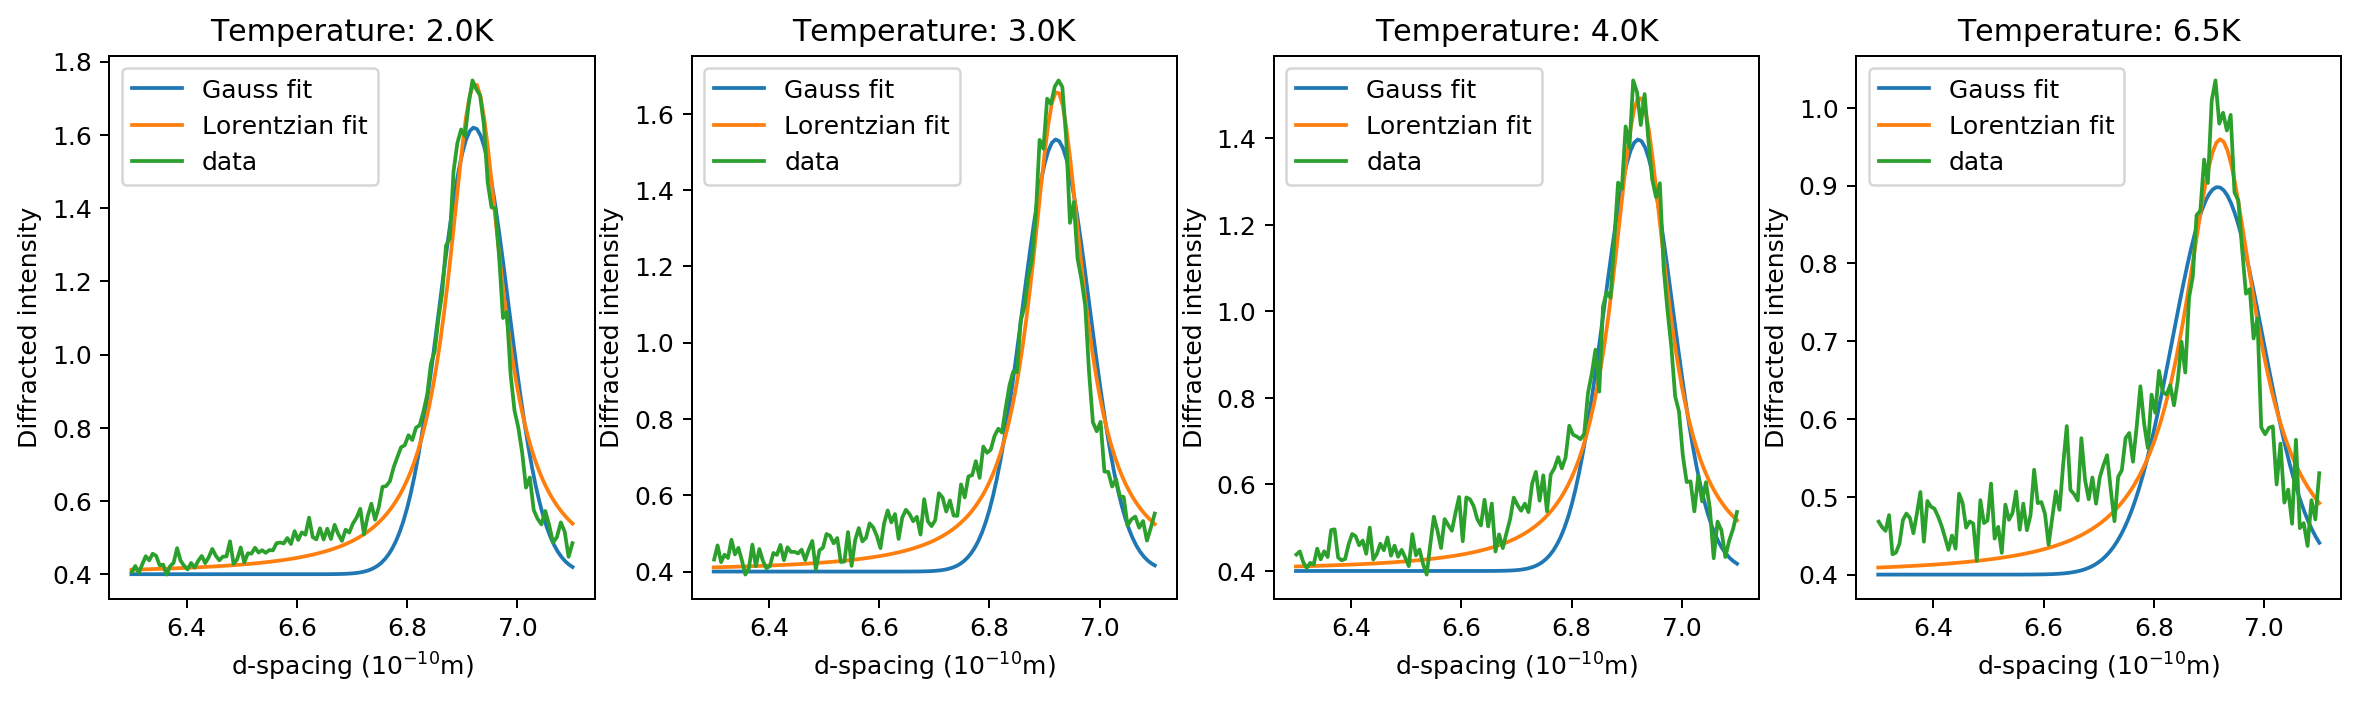

In [32]:
fig=plt.figure(figsize=(16, 4), dpi= 180, facecolor='w', edgecolor='k')
total=4
x_diffraction = np.linspace(6.3,7.1,121)
print("  Amplitude    Centre       Width  ","{:^15s}{:^15s}{:^15s}".format("Temperature","Lorentzian chi","Gaussian chi"))
    #print("  Amplitude    Centre       Width    Temperature     Lorentzian chi   Gaussian chi")
intensity2_t = []
for i in range(total):
    values,Lchi_val,Gchi_val=Curve_2(i+1,total,filenames[i])
    print(values,"{:^10}{:15.6f}{:15.6f}".format(temperatures[i],Lchi_val,Gchi_val))
        #print(values,'','','',temperatures[i],'','','','','',Lchi_val,'','','',Gchi_val)
    intensity2_t.append(np.trapz(L(x_diffraction,*values),x_diffraction))
plt.show()

The figures above show that the diffraction intensity peaks can be accurately modelled using a Lorentzian function. However, above the critical temperature the peak is not sufficiently large to be modelled by a Lorentzian function. Thus, for $T\geq T_0$, we used the values obtained previously with np.trapz. We integrated the Lorentzian functions for $2\leq T \leq 6.5$ to obtain a Lorentzian instensity and appended the np.trapz values for $T\geq 6.5$ to this list, giving the following $Intensity(T)$.

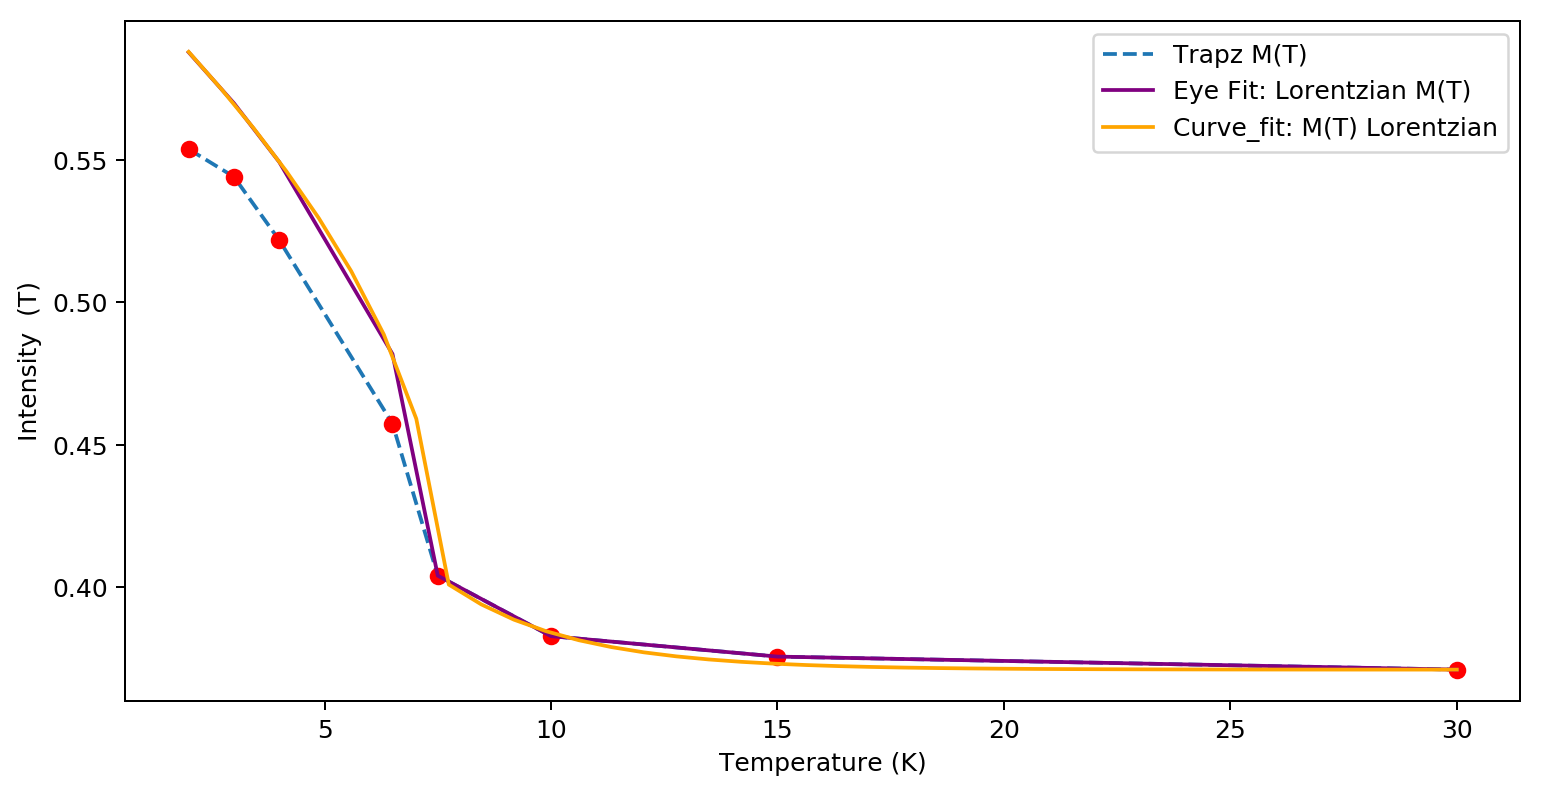

In [33]:
fig=plt.figure(figsize=(10, 5), dpi= 180, facecolor='w', edgecolor='k')

lorentzian_intensity_t=[0.5876664335704882, 0.56979791170994654, 0.54918501329847758, 0.48187487475065283,0.40413061866560007, 0.38292780808670013, 0.37575071092150003, 0.37118946598635005]
Lgood_param=np.array([0.084,7.6,0.56,0.374,0.3,0.03])
L_fitted=MSci(x_values,*Lgood_param)
plt.plot(temperatures,intensity_t,linestyle= 'dashed',label="Trapz M(T)")
plt.plot(temperatures,intensity_t,'o',color='r')
plt.plot(temperatures,lorentzian_intensity_t,label="Eye Fit: Lorentzian M(T)",color='purple')
solutionsLorentz,covariance = curve_fit(MSci,np.array(temperatures),lorentzian_intensity_t, Lgood_param)
plt.plot(x_values,MSci(x_values,*solutionsLorentz),label="Curve_fit: M(T) Lorentzian",color='orange')
plt.xlabel("Temperature (K)")
plt.ylabel("Intensity  (T)")
plt.legend()
plt.show()

The figure shows the original $I(T)$ as $Trapz (T)$ as well as $I(T)$ after modelling the raw data with Lorenztian functions as $curve_-fit: M(T) Lorentzian$. We can see that fitting the raw data with Lorenztian increased the area under the curve and thus will over-estimate the value for the critical exponent $\beta$.

### 3.3 Transition Temperature and Critical Exponent

In [12]:
print("{:^25s}{:^25s}{:^25s}".format("Method","Transition Temperature","Critical Exponent"))
print("{:^25s}{:^25.8f}{:^25.8f}".format("Trapz + Mup + curve_fit",solutions1[1],solutions1[2]))
print("{:^25s}{:^25.8f}{:^25.8f}".format("Lorentz + Mup + curve_fit",solutionsLorentz[1],solutionsLorentz[2]))

         Method           Transition Temperature      Critical Exponent    
 Trapz + Mup + curve_fit        7.49999978               0.34355836        
Lorentz + Mup + curve_fit       7.49999808               0.55728881        


In the reference paper [[1](http://dx.doi.org/10.1039/C6TC03992H)] the calculated value for the critical exponent $\beta = 0.45$, which tells us that the under-estimated value from directly integrating the data can be compensated by fitting the data with Lorentzian functions since the reference value is the average between the two values obtained. The literature value for the transition temperature is 8.0K and although our results show $T_0=7.5K$, this is the point at which the function begins to behave as an exponential. Therefore, the actual value for the transition temperature will be close to the intercept with the T axis, so that $7.5 \leq T_0 \leq 8.0$. Extrapolating the gradient gives a value $T_0 = 7.7K$.

## 4. Discussion

Numerical methods and curve fitting are essential for data analysis. The results expressed previously highlight the need for accurate mathematical models in order to use numerical methods with more flexibility. However, there a clear distinction should be made between accurately fitting the data and obtaining accurate results. 

For example, it was shown how $M_{updated}(T)$ was an incredible fit to the data but it gave a value for the transition temperature lower than it actually is. The original model for $M(T)$ did not have the exponential decay, so the point at which it became constant was almost the transition value giving a value $T_0=7.6K$, whereas for $M_{updated}(T)$ the transition value should be found by extrapolating the gradient until it intercepts with the Temperature axis, giving a value of $T_0 = 7.7K$.

This is further supported by the fact that the reference value for transition temperature is $T_0 = 8.0K$ as seen in their figure 4, but only has 3 recorded values before $T_0$ suddenly drops, indicating that the actual transition temperature value is slightly less than 8K.

Despite this subtlety in results, the high susceptibity to initial conditions due to the sharp discontinuity for $M(T)$ implied that neither curve_fit nor matrix operations + Newton-Raphson could be used reliably, or whether they could be used at all. $M_{updated}(T)$ was particularly flexible and not as susceptible to initial conditions when used with curve_fit, and the initial parameters only needed to simply represent the general shape of the curve for curve_fit to converge to very accurate values. One of the key advantages of $M_{updated}(T)$ is that it allows matrix-operation + Newton-Raphson to be used provided the initial parameters are good eye approximation to the given data. The reduced chi-squared values obtained after fitting when the initial parameters were sensible, show that $M_{updated}(T)$ is a very good model function to fit the data using both curve_fit and matrix operation + Newton-Raphson. 

The diffraction intensity peaks tried to be modelled by Gaussian, Lorenztian and pseudo Voigt functions. Although pseudo-Voigt is a more sophisticated fitting function, it would only be useful for the $T \geq 7.5$, at which point the peaks are too small to be modelled. Also, sophisticated peak fitting algorithms exist 
[[2](https://chrisostrouchov.com/post/peak_fit_xrd_python/)], 
but the Lorentzian function gave a sufficiently good fit as an introduction to peak fitting.  Once the diffraction peaks were modelled, the resulting $Intensity(T)$ was of the desired shape but slighlt over-estimated the critical exponent $\beta = 0.55$. We found that integrating the raw data under-estimated the critial exponent $\beta = 0.35$ and that the reference value was exactly the average between the two values obtain $\beta = 0.45$. This is an indication that fitting the diffraction peaks with Lorentzian functions was a good choice, that confirms the already known value for the critical exponent.

Future work in the topic should consider a thourough peak modelling of the data. This would allow to calculate a more accurate avarge value for the critical exponent which should still be within $0.35 \leq \beta \leq 0.55 $. Another improvement to the results expressed previously is collecting more diffraction intensity data for $6\leq T \leq 9$ as this would allow to have more data-points close to the transition temperature. Nonetheless, the reader is strongly encouraged to use $M_{updated}(T)$ over $M(T)$ for curve fitting future data, although careful considerations should be taken when analysing the results obtained.

## 5. Conclusions

$M_{updated}(T)$ is a superior model function than $M(T)$ to the data given, provided the tranistion temperature value is extrapolated and carefully compared to the reference value. The transition temperature obtained was $T_0 = 7.7K$.

$M(T)$ slightly under-estimated the value for the critical exponent $\beta = 0.35$, but since the diffractiong peaks are of a known shape, they can be modelled with Lorentzian functions, giving a sligthly over-estimated value $\beta = 0.55$. Therefore, the average of the two methods gives $\beta = 0.45$ which is in accordance with the reference value.
   
Matrix operation + Newton-Raphson is more susceptible to poor initial conditions than curve_fit but both can be used provided the fitting function is already a good model of the data analysed and that the initial parameters are already a reasonable fit to the function.

## References

[1] J. Mater. Chem. C, 2016, 4, 11164

[2] C. OstrouchovPeak, fitting XRD data with Python, accessed 04/11/2018

[3] Mantid, Pseudo Voigt, version: 19/03/2018

[4] Birkbeck College, University of London, Peak Shapes, accessed 06/11/2018

[5] C. G. Shull, W. A. Strauber, AID E. O. Wollan, Physical Review Vol. 83, N. 2 July, 1951